In [1]:
import numpy as np
import tonic.transforms as transforms
import tonic
from torchvision import transforms as tt
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn
from torchvision.transforms.functional import InterpolationMode


import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
from tqdm.notebook import tqdm
from statistics import mean

import snntorch as snn

In [2]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dirs: list,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dirs = dirs
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size

        self.length = 0
        self.lengths = []
        for dir in self.dirs:
            curr_len = np.load(dir + "/length.npy")
            self.length += curr_len
            self.lengths.append(curr_len)

    def find_num_classes_in_dataset():
        self.num_classes_in_dataset = 0
        self.classes = torch.empty((1, ))
        for idx in range(0, len(self)):
            dir, index = self.get_dir_index(idx)

            item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
            mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

            classes = torch.unique(mask, sorted=False)
            self.classes = torch.cat((self.classes, classes), dim=0)

        self.classes = torch.unique(self.classes)
        self.num_classes_in_dataset = int(self.classes.max()) + 1
            

    def get_dir_index(self, index):
        curr_idx_sum = 0
        for i, length in enumerate(self.lengths):
            #print(index, length, curr_idx_sum)
            if curr_idx_sum <= index < curr_idx_sum + length:
                dir = self.dirs[i]
                index -= curr_idx_sum
                break
            curr_idx_sum += length
                

        return dir, index

    def __getitem__(self, index):
        dir, index = self.get_dir_index(index)
        
        item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()

        events = np.asarray(item["events"])

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame),
                                        
                                      ])

        events = torch.from_numpy(frame_transform(events)).to(dtype)

        events = tt.functional.resize(events, (int(input_size[0]/2), int(input_size[1]/2)), interpolation=InterpolationMode.NEAREST)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        #mask = torch.nn.functional.one_hot(mask, num_classes_in_dataset=num_classes_in_dataset).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        mask = tt.functional.resize(mask, self.output_size, antialias=True, interpolation=InterpolationMode.NEAREST_EXACT)


        if num_classes_in_output != num_classes_in_dataset:
            if num_classes_in_output == 2:
                mask = torch.where(mask > 0, 1, 0)
            if num_classes_in_output == 3:
                mask = torch.where((mask == 9.0) | (mask == 22.0), 1, mask)
                mask = torch.where((mask != 1) & (mask != 0), 2, mask)
        
        return events, mask.squeeze().to(dtype)#resized_mask.squeeze()

    def get_original_mask(self, index):
        dir, index = self.get_dir_index(index)
        
        item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    # def get_item(self, index):
    #     item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
    #     return item


In [3]:
num_bins_per_frame = 4 # T = 100
framerate = 200

sensor_size = [640, 480, 2]
output_size=(30, 40)
input_size=(480, 640)
num_classes_in_dataset = 25
num_classes_in_output = 3

dtype=torch.float

In [4]:
dirs = ["./EVIMO/left_cam/scene13_test5",
       "./EVIMO/left_cam/scene14_test3",
       "./EVIMO/left_cam/scene15_test1"]

In [5]:
dataset = EVIMOMask(dirs=dirs, output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [6]:
bins, mask = dataset[1000]

In [7]:
bins.shape

torch.Size([4, 1, 240, 320])

In [8]:
mask.shape

torch.Size([30, 40])

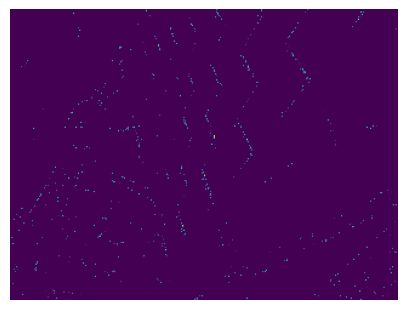

In [9]:
animation = tonic.utils.plot_animation(bins.numpy())
from IPython.display import HTML

HTML(animation.to_jshtml())

In [10]:
len(dataset)

2181